# MDP with Unmeasured Confounders

The model we are using:  
Medical Treatment model as defined in Appendix A in https://causalai.net/mdp-causal.pdf  
Here, there is a slight difference in physician's policy to ensure there is randomness in the physician's policy

In [46]:
import numpy as np
def physicains_policy(St, Mt, Et):
    p = 0.1
    # physician's policy is pi(St, Mt, Et) = St XOR Mt XOR Et XOR Z
    # where Z is Bern(p) random variable
    Z = np.random.binomial(1, p)
    return (St+Mt+Et+Z) % 2

In [47]:

# probability_yt_is_1 is a 4 dimensional array
# format: probability_yt_is_1[St][Mt][Et][Xt] is P(Yt = 1 | Xt, St, Mt, Et)
probability_yt_is_1 = np.zeros((2,2,2,2))
probability_yt_is_1[0][0][0][0] = 0.2
probability_yt_is_1[0][0][0][1] = 0.9
probability_yt_is_1[0][0][1][0] = 0.9
probability_yt_is_1[0][0][1][1] = 0.2
probability_yt_is_1[0][1][0][0] = 0.8
probability_yt_is_1[0][1][0][1] = 0.3
probability_yt_is_1[0][1][1][0] = 0.3
probability_yt_is_1[0][1][1][1] = 0.8

probability_yt_is_1[1][0][0][0] = 0.7
probability_yt_is_1[1][0][0][1] = 0.2
probability_yt_is_1[1][0][1][0] = 0.2
probability_yt_is_1[1][0][1][1] = 0.7
probability_yt_is_1[1][1][0][0] = 0.1
probability_yt_is_1[1][1][0][1] = 0.8
probability_yt_is_1[1][1][1][0] = 0.8
probability_yt_is_1[1][1][1][1] = 0.1

In [48]:
# transition_prob is a 2 dimensional array
# format: transition_prob[Xt][St] = P(St+1 = 0 | St, Xt)
transition_prob = np.zeros((2,2))
transition_prob[0][0] = 0.9
transition_prob[0][1] = 0.3
transition_prob[1][0] = 0.7
transition_prob[1][1] = 0.8

In [49]:
def get_Yt(St, Mt, Et, Xt):
    u = np.random.rand()
    if u < probability_yt_is_1[St][Mt][Et][Xt]:
        return 1
    return 0

In [50]:
def get_next_state(St, Xt):
    u = np.random.rand()
    if u < transition_prob[Xt][St]:
        return 0
    return 1

# Generate data from our model

In [51]:
import pandas as pd

data_df = pd.DataFrame()

In [52]:
def generate_single_trajectory(patient_id):
    global data_df
    St = np.random.randint(2)
    for t in range(100):
        Mt, Et = np.random.randint(2), np.random.randint(2)
        Xt = physicains_policy(St, Mt, Et)
        Yt = get_Yt(St, Mt, Et, Xt)
        data_df = data_df.append({'pt_id': patient_id,'t': t, 'St': St, 'Mt': Mt, 'Et': Et, 'Xt': Xt, 'Yt': Yt}, ignore_index=True)
        St = get_next_state(St, Xt)

In [53]:
for patient_id in range(5000):
    if patient_id % 500 == 0:
        print("Iteration number: ", patient_id)
    generate_single_trajectory(patient_id)

Iteration number:  0
Iteration number:  500
Iteration number:  1000
Iteration number:  1500
Iteration number:  2000
Iteration number:  2500
Iteration number:  3000
Iteration number:  3500
Iteration number:  4000
Iteration number:  4500


In [54]:
data_df.to_csv('/Users/faaiz/MDPUC/data-model2.csv')

In [55]:
data_df.head()

,Et,Mt,St,Xt,Yt,pt_id,t
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,1.0,0.0,0.0,1.0,0.0,0.0,3.0
4,0.0,1.0,0.0,1.0,0.0,0.0,4.0


In [56]:
############## Define parameters #################

n_states = 2
n_actions = 2

### Divide the data into training and testing sets

In [57]:
patients = data_df['pt_id'].unique()
training = patients[np.random.randint(5, size = (len(patients))) != 4]
testing = patients[np.random.randint(5, size = (len(patients))) == 4]

train_data = data_df.loc[data_df['pt_id'].isin(training)].reset_index()
test_data = data_df.loc[data_df['pt_id'].isin(testing)].reset_index()

# Finding optimal policy assuming the confounders $E_{t}$ and $M_{t}$ are not measured
The states of MDP are $S_t$, actions are $X_t$ and rewards are $Y_t$
### 1. Estimating the Transition matrix T(S,S',A) and Reward matrix R(S,A)

In [58]:
from util_functions import *

transition, R, sums = compute_transitions_and_rewards(train_data, n_states=2, n_actions=2)

Sanity Check to make sure transition matrix estimate is accurate

In [59]:
transition

array([[[0.89980509, 0.69999093],
        [0.10019491, 0.30000907]],

       [[0.2981046 , 0.80180044],
        [0.7018954 , 0.19819956]]])

Estimate physician's policy from data

In [60]:
physpol = (sums.T/((sums.sum(axis=1)==0) + (sums.sum(axis=1)))).T

### 2. Do policy iteration

In [107]:
from mdp_utils import *

gamma = 0.99
n_states = 2
V, policy, i, Qon = mdp_policy_iteration_with_Q(transition, R, gamma, np.ones(n_states))
OptimalAction = Qon.argmax(axis=1) # deterministic

In [108]:
Qon

array([[29.84332118, 29.82278727],
       [29.68037489, 29.73457135]])

In [63]:
V

array([29.84332118, 29.73457135])

#### Compare this with policy iteration on complete model (with no missing confounders)

In [64]:
complete_model_train = train_data.copy()
complete_model_train['St'] = complete_model_train['Et'] + 2*complete_model_train['Mt'] + 4*complete_model_train['St']
complete_model_train.drop(columns=['Et', 'Mt'], inplace=True)
complete_model_train.head()


,index,St,Xt,Yt,pt_id,t
0,400,4.0,1.0,0.0,4.0,0.0
1,401,2.0,1.0,0.0,4.0,1.0
2,402,1.0,1.0,0.0,4.0,2.0
3,403,3.0,0.0,0.0,4.0,3.0
4,404,2.0,1.0,1.0,4.0,4.0


In [65]:
n_states=8
transition_complete, R_complete, sums_complete = compute_transitions_and_rewards(complete_model_train, n_states=8, n_actions=2)
V_complete, policy_complete, i, Qon_complete = mdp_policy_iteration_with_Q(transition_complete, R_complete, gamma, np.ones(n_states))


In [66]:
s = complete_model_train.loc[complete_model_train['St']==0]
(s.loc[s['Xt']==0, 'Yt']==1).mean()

0.1997030551643911

In [67]:
policy_complete

array([1, 0, 0, 1, 0, 1, 1, 0])

In [68]:
Qon_complete

array([[82.09734435, 82.78018933],
       [82.7987918 , 82.0709395 ],
       [82.69647811, 82.16852266],
       [82.1967313 , 82.67848085],
       [82.53299611, 82.08699121],
       [82.01857069, 82.59032256],
       [81.91770974, 82.68187731],
       [82.61543673, 81.98562217]])

In [69]:
V_complete

array([82.78018933, 82.7987918 , 82.69647811, 82.67848085, 82.53299611,
       82.59032256, 82.68187731, 82.61543673])

### 3. Off policy evaluation on Test dataset

In [70]:
from util_functions import *

OPevaluation_data, bootwis = evaluate_policy(test_data, OptimalAction, n_states=2, n_actions=2, gamma=0.99, n_iters=100)


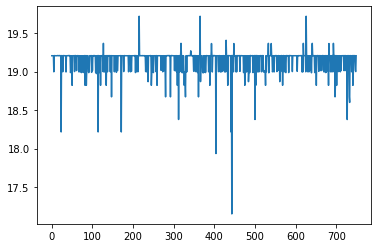

In [109]:
import matplotlib.pyplot as plt

plt.plot(bootwis)
plt.show()

In [115]:
policy = OptimalAction
Q_policy1 = mdp_eval_Q_matrix(transition, R, 0.99, policy)
Q_policy1

array([[29.84332118, 29.82278727],
       [29.68037489, 29.73457135]])

# Calculating Actual value of the policy in a model with all confounders

We define a state variable $S'_t$ which contains information about all confounders

In [72]:
complete_model_test = test_data.copy()

In [73]:
complete_model_test['St'] = complete_model_test['Et'] + 2*complete_model_test['Mt'] + 4*complete_model_test['St']
complete_model_test.drop(columns=['Et', 'Mt'], inplace=True)
complete_model_test.head()

,index,St,Xt,Yt,pt_id,t
0,100,3.0,1.0,1.0,1.0,0.0
1,101,0.0,0.0,0.0,1.0,1.0
2,102,1.0,1.0,0.0,1.0,2.0
3,103,4.0,1.0,0.0,1.0,3.0
4,104,1.0,1.0,0.0,1.0,4.0


In [74]:
def mapDeterministicPolicyToNewStateSpace(policy):
    mapped_policy = np.zeros(8)
    for i in range(4):
        mapped_policy[i] = policy[0]
    for i in range(4,8):
        mapped_policy[i] = policy[1]
    return mapped_policy

In [75]:
newOptimalPolicy = mapDeterministicPolicyToNewStateSpace(OptimalAction)

In [76]:
from util_functions import *

complete_model_test_p1, bootwis_actual = evaluate_policy(complete_model_test, newOptimalPolicy, n_states=8, n_actions=2, gamma=0.99, n_iters=100)


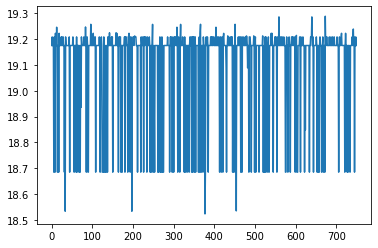

In [77]:
plt.plot(bootwis_actual)
plt.show()

In [116]:
policy = newOptimalPolicy
Q_policy1_actual = mdp_eval_Q_matrix(transition_complete, R_complete, 0.99, policy)
Q_policy1_actual

array([[53.57238207, 54.25965202],
       [54.27762565, 53.55182307],
       [54.17797973, 53.65149244],
       [53.67276384, 54.15933555],
       [54.02428309, 53.56767401],
       [53.51173821, 54.07529784],
       [53.41258246, 54.16374899],
       [54.10842079, 53.4656028 ]])

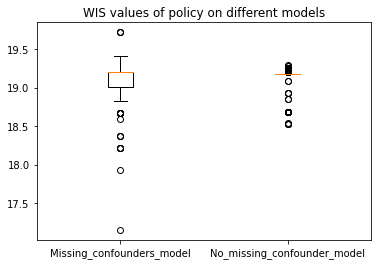

In [78]:
data = [bootwis, bootwis_actual]
fig, ax = plt.subplots()
ax.set_title('WIS values of policy on different models')
ax.boxplot(data)
plt.xticks([1,2],['Missing_confounders_model','No_missing_confounder_model'])
plt.show()

In [88]:
bootwis_actual.mean(), bootwis_actual.std()

(19.098024357745476, 0.1901496155451614)

In [89]:
bootwis.mean(), bootwis.std()

(19.136852976975923, 0.1703706931829822)

# We now repeat the evaluation for policy $\pi$ defined by $\pi(S_t = 0) = 1$ and $\pi(S_t = 1) = 0$

#### 1. Policy evaluation with unmeasured confounders

In [81]:
policy = np.array([1,0])

OPevaluation_data_p2, bootwis_p2 = evaluate_policy(test_data, policy, n_states=2, n_actions=2, gamma=0.99, n_iters=100)


#### 2. Policy evaluation on complete model (with confounders $E_t$ and $M_t$ included)

In [82]:
mapped_policy = mapDeterministicPolicyToNewStateSpace(policy)

complete_model_test_p2, bootwis_actual_p2 = evaluate_policy(complete_model_test, mapped_policy, n_states=8, n_actions=2, gamma=0.99, n_iters=100)


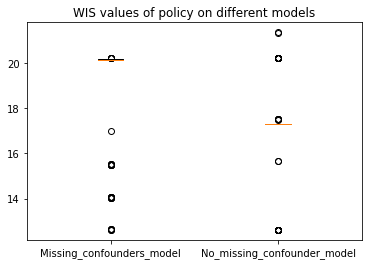

In [83]:
data = [bootwis_p2, bootwis_actual_p2]
fig, ax = plt.subplots()
ax.set_title('WIS values of policy on different models')
ax.boxplot(data)
plt.xticks([1,2],['Missing_confounders_model','No_missing_confounder_model'])
plt.show()

In [86]:
bootwis_actual_p2.mean(), bootwis_actual_p2.std()

(17.166333635721617, 2.192621190612842)

In [87]:
bootwis_p2.mean(), bootwis_p2.std()

(18.8240204770057, 2.4957153669397747)

In [117]:
policy = np.array([1,0])
Q_policy2 = mdp_eval_Q_matrix(transition, R, 0.99, policy)
Q_policy2

array([[26.16107839, 26.12948547],
       [25.96483009, 26.04690435]])

In [118]:
newPolicy = mapDeterministicPolicyToNewStateSpace(policy)
Q_policy2_actual = mdp_eval_Q_matrix(transition_complete, R_complete, 0.99, newPolicy)
Q_policy2_actual

array([[50.10764533, 50.78334063],
       [50.80506587, 50.07285319],
       [50.69898642, 50.16808033],
       [50.20542057, 50.6813963 ],
       [50.51996185, 50.09033379],
       [50.00355577, 50.58949374],
       [49.9013494 , 50.68156621],
       [50.60053297, 49.98926081]])

### Causal bound evaluation as described in https://papers.nips.cc/paper/2019/file/8252831b9fce7a49421e622c14ce0f65-Paper.pdf   
For the purposes of this analysis, we assume this is a single decision regime (SDR) 

Corollar 1. For a DTR, given $P({\bar{s}}_K, {\bar{x}}_K, y) > 0$,  

$\frac{E[Y|{\bar{s}}_K, {\bar{x}}_K]P({\bar{s}}_K, {\bar{x}}_K)}{\Gamma({\bar{s}}_K, {\bar{x}}_{K-1})} \leq E_{{\bar{x}}_K}[Y|{\bar{s}}_K] \leq 1 - \frac{(1 - E[Y|{\bar{s}}_K, {\bar{x}}_K])P({\bar{s}}_K, {\bar{x}}_K)}{\Gamma({\bar{s}}_K, {\bar{x}}_{K-1})}$

#### We want to use this bound to estimate the value of $E_{X=0}[Y|S=0]$ (with unmeasured confounders)

We know that the true value of this quantity is:  
$P(Y=1 | S = 0,  X = 0) = \sum_e \sum_m P(Y=1 | S = 0,  X = 0, E = e, M = m)P(E=e)P(M=m)$  
$=\frac{1}{4}(0.2+0.8+0.9+0.3) = 0.55$

In [129]:
first_step = train_data.loc[train_data['t']==0].reset_index()

In [143]:
n_states=2
sums_SDR = np.zeros((n_states, n_actions)) 
R_SDR = np.zeros((n_states, n_actions))

for index, row in first_step.iterrows():
    S0, action, Y = int(first_step.at[index, 'St']), int(first_step.at[index, 'Xt']), int(first_step.at[index, 'Yt'])
    sums_SDR[S0][action] += 1
    R_SDR[S0][action] += Y
    
for i in range(n_states):
    for j in range(n_actions):
        if sums_SDR[i][j] != 0:
            R_SDR[i][j] = R_SDR[i][j] / sums_SDR[i][j]

In [158]:
R_SDR

array([[0.33067729, 0.31654676],
       [0.20812183, 0.20177165]])

In [151]:
lower_bound = R_SDR[0][0]*sums[0][0]/sums[0].sum()

In [152]:
lower_bound

0.1658505689468338

In [149]:
upper_bound = 1 - (1-R_SDR[0][0])*sums[0][0]/sums[0].sum()

In [150]:
upper_bound

0.6643024628546015

#### Similarly for $E_{X=1}[Y|S=0]$ 

We know that the true value of this quantity is:  
$P(Y=1 | S = 0,  X = 1) = \sum_e \sum_m P(Y=1 | S = 0,  X = 1, E = e, M = m)P(E=e)P(M=m)$  
$=\frac{1}{4}(0.9+0.2+0.3+0.8) = 0.55$

In [153]:
lower_bound = R_SDR[0][1]*sums[0][1]/sums[0].sum()
lower_bound

0.15778333332332212

In [155]:
upper_bound = 1 - (1-R_SDR[0][1])*sums[0][1]/sums[0].sum()
upper_bound

0.6593314394155545

#### Similarly for $E_{X=0}[Y|S=1]$ 

We know that the true value of this quantity is:  
$P(Y=1 | S = 1,  X = 0) = \sum_e \sum_m P(Y=1 | S = 1,  X = 0, E = e, M = m)P(E=e)P(M=m)$  
$=\frac{1}{4}(0.7+0.2+0.1+0.8) = 0.45$

In [156]:
lower_bound = R_SDR[1][0]*sums[1][0]/sums[1].sum()
lower_bound

0.10466938841110272

In [157]:
upper_bound = 1 - (1-R_SDR[1][0])*sums[1][0]/sums[1].sum()
upper_bound

0.6017457416553165